In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from IPython.display import display



In [6]:
!pip install display

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'display' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'display'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for display: filename=display-1.0.0-py3-none-any.whl size=1406 sha256=9cc70c76f031f1efadc58ce472486fc3e5d52bd36527da5720ea9eb56b416489
  Stored in directory: /gpfs/data/oermannlab/users/schula12/.cache/pip/wheels/c8/03/f5/a10e442f4903dd16b0e7914afe0f24392305535fd6f9cef522
Successfully built display


In [ ]:
#Segmented Data with volumetric features and DICE scores 
filepath = "/gpfs/data/oermannlab/users/schula12/Morphology/Lumiere/InTheSheets/patients_cases_true_lesion_analysis_CORRECTED_IDs_CLEAN.csv"
df = pd.read_csv(filepath)
display(df.head)

#clinical data 
clin_df = pd.read_csv("/gpfs/data/oermannlab/users/schula12/all_fractal_results/LUMIERE-Demographics_Pathology.csv")
print (list(clin_df.columns))

display(clin_df.head())

<bound method NDFrame.head of       patient_id  case_id  response  baseline_week  followup_week  \
0    Patient-001  case_01         2              0             44   
1    Patient-002  case_01         2              3             21   
2    Patient-002  case_02         3              3             37   
3    Patient-002  case_03         3             40             47   
4    Patient-003  case_01         2              0             14   
..           ...      ...       ...            ...            ...   
230  Patient-085  case_03         3              1             50   
231  Patient-087  case_01         3              0             24   
232  Patient-090  case_01         3              0             29   
233  Patient-091  case_01         3              1             26   
234  Patient-091  case_02         3              1             43   

     time_difference_weeks  time_difference_days  \
0                       44                   308   
1                       18           

['Patient', 'Survival time (weeks)', 'Sex', 'Age at surgery (years)', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative', 'MGMT quantitative']


,Patient,Survival time (weeks),Sex,Age at surgery (years),IDH (WT: wild type),IDH method,MGMT qualitative,MGMT quantitative
0,Patient-001,89,female,57,WT,BES,methylated,na
1,Patient-002,48,female,71,na,na,not methylated,0.00%
2,Patient-003,40,male,39,WT,Immuno,not methylated,0.00%
3,Patient-004,110,male,69,WT,Sanger Sequencing,not methylated,0.00%
4,Patient-005,53,male,66,WT,Immuno,not methylated,0.00%


['Patient', 'Survival time (weeks)', 'Sex', 'Age at surgery (years)', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative', 'MGMT quantitative']


,Patient,Survival time (weeks),Sex,Age at surgery (years),IDH (WT: wild type),IDH method,MGMT qualitative,MGMT quantitative
0,Patient-001,89,female,57,WT,BES,methylated,na
1,Patient-002,48,female,71,na,na,not methylated,0.00%
2,Patient-003,40,male,39,WT,Immuno,not methylated,0.00%
3,Patient-004,110,male,69,WT,Sanger Sequencing,not methylated,0.00%
4,Patient-005,53,male,66,WT,Immuno,not methylated,0.00%


In [37]:
#adding features 
import sys
sys.path.append("/gpfs/data/oermannlab/users/schula12/Morphology/Lumiere/AllMyPythons")
from MorphFeatureClass import TumorMorphology

In [39]:
import nibabel as nib
morphology = TumorMorphology(use_gpu=True)

# Storage
results = []

# Loop through each row
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        seg_paths = {
            'baseline': Path(row['baseline_swin_path']),
            'followup': Path(row['followup_swin_path']),
        }

        for timepoint, seg_path in seg_paths.items():
            seg_data = nib.load(seg_path).get_fdata().astype(int)

            # Whole tumor mask: any of labels 1, 2, 3
            tumor_mask = (seg_data > 0)  # Label 0 is background

            volume = tumor_mask.sum()
            if volume == 0:
                compactness = None
                fractal = None
            else:
                sa = morphology.calculate_surface_area(tumor_mask)
                compactness = morphology.calculate_compactness(volume, sa)
                fractal, _ = morphology.box_counting_3d_gpu(tumor_mask)

            results.append({
                'patient_id': row['patient_id'],
                'case_id': row['case_id'],
                'timepoint': timepoint,
                'compactness_whole': compactness,
                'fractal_whole': fractal,
            })

    except Exception as e:
        print(f"❌ Error for {row['patient_id']} {row['case_id']} {timepoint}: {e}")

# Save and view
whole_tumor_df = pd.DataFrame(results)
whole_tumor_df.to_csv("morphology_whole_tumor.csv", index=False)
whole_tumor_df.head()

100%|██████████| 235/235 [11:38<00:00,  2.97s/it]


,patient_id,case_id,timepoint,compactness_whole,fractal_whole
0,Patient-001,case_01,baseline,0.031979,2.466428
1,Patient-001,case_01,followup,0.112725,2.539051
2,Patient-002,case_01,baseline,0.121039,2.611753
3,Patient-002,case_01,followup,0.022632,1.953450
4,Patient-002,case_02,baseline,0.121039,2.611753


In [41]:
# After the loop and DataFrame creation
wide_df = whole_tumor_df.pivot(index=['patient_id', 'case_id'], columns='timepoint')

# Flatten MultiIndex columns
wide_df.columns = [f"{t}_{metric}" for metric, t in wide_df.columns]

# Reset index to merge later
wide_df = wide_df.reset_index()
wide_df.head(10)


,patient_id,case_id,baseline_compactness_whole,followup_compactness_whole,baseline_fractal_whole,followup_fractal_whole
0,Patient-001,case_01,0.031979,0.112725,2.466428,2.539051
1,Patient-002,case_01,0.121039,0.022632,2.611753,1.953450
2,Patient-002,case_02,0.121039,0.047393,2.611753,2.536844
3,Patient-002,case_03,0.022226,0.085640,2.227916,2.579914
4,Patient-003,case_01,0.086244,0.101249,2.673962,2.625304
5,Patient-003,case_02,0.086244,0.113752,2.673962,2.640321
6,Patient-003,case_03,0.086244,0.022258,2.673962,2.605044
7,Patient-004,case_01,0.077437,0.013762,2.642269,2.349493
8,Patient-004,case_02,0.077437,0.016586,2.642269,2.452140
9,Patient-004,case_03,0.013772,0.023126,2.442809,2.526886


In [48]:
wide_df = whole_tumor_df.pivot(index=['patient_id', 'case_id'], columns='timepoint')
wide_df.columns = [f"{t}_{metric}" for metric, t in wide_df.columns]
wide_df = wide_df.reset_index()
df_merged = df.merge(wide_df, on=["patient_id", "case_id"], how="left")


In [49]:
df_merged.head()

,patient_id,case_id,response,baseline_week,followup_week,time_difference_weeks,time_difference_days,baseline_gt_original_path,baseline_swin_path,followup_gt_original_path,...,swin_regions_with_new_lesions,swin_regions_with_lost_lesions,swin_most_affected_region,swin_true_progression_severity,swin_total_lesion_activity,swin_progression_vs_response_ratio,baseline_compactness_whole,followup_compactness_whole,baseline_fractal_whole,followup_fractal_whole
0,Patient-001,case_01,2,0,44,44,308,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,NaN,enhancing|necrotic|edema,NaN,significant_response,5,0.0,0.031979,0.112725,2.466428,2.539051
1,Patient-002,case_01,2,3,21,18,126,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,necrotic,enhancing|edema,necrotic,moderate_progression,4,1.0,0.121039,0.022632,2.611753,1.953450
2,Patient-002,case_02,3,3,37,34,238,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,necrotic,NaN,necrotic,moderate_progression,1,1.0,0.121039,0.047393,2.611753,2.536844
3,Patient-002,case_03,3,40,47,7,49,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,enhancing|edema,necrotic,enhancing,severe_progression,4,3.0,0.022226,0.085640,2.227916,2.579914
4,Patient-003,case_01,2,0,14,14,98,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,NaN,enhancing|necrotic|edema,NaN,significant_response,5,0.0,0.086244,0.101249,2.673962,2.625304


,patient_id,case_id,response,baseline_week,followup_week,time_difference_weeks,time_difference_days,baseline_gt_original_path,baseline_swin_path,followup_gt_original_path,...,enhancing_volume_change,enhancing_volume_volatility,binary_response,Survival time (weeks),Sex,Age at surgery (years),IDH (WT: wild type),IDH method,MGMT qualitative,MGMT quantitative
0,Patient-001,case_01,2,0,44,44,308,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-5294,-120.318182,0,89,female,57,WT,BES,methylated,na
1,Patient-002,case_01,2,3,21,18,126,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-11077,-615.388889,0,48,female,71,na,na,not methylated,0.00%
2,Patient-002,case_02,3,3,37,34,238,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-4962,-145.941176,1,48,female,71,na,na,not methylated,0.00%
3,Patient-002,case_03,3,40,47,7,49,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,32382,4626.000000,1,48,female,71,na,na,not methylated,0.00%
4,Patient-003,case_01,2,0,14,14,98,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-17155,-1225.357143,0,40,male,39,WT,Immuno,not methylated,0.00%


# Add columns of change and volatility (this will become a separate script)

In [43]:
from scipy.stats import kruskal, spearmanr
import numpy as np

def add_volume_change_features(df, features, baseline_prefix="baseline_swin_", followup_prefix="followup_swin_"):
    """
    Adds change and volatility columns for each feature in the provided list.
    
    Parameters:
    - df: input DataFrame
    - features: list of feature names (e.g., ['whole_tumor_volume', 'edema_volume'])
    - baseline_prefix: prefix for baseline columns
    - followup_prefix: prefix for followup columns
    
    Returns:
    - df with new columns: `<feature>_change`, `<feature>_volatility`
    """
    for feat in features:
        base_col = baseline_prefix + feat
        follow_col = followup_prefix + feat
        change_col = f"{feat}_change"
        volatility_col = f"{feat}_volatility"
        print(f"For feature '{feat}', the following columns in {base_col} and {follow_col} are being created: '{change_col}' (difference between follow-up and baseline) and '{volatility_col}' (change per week, i.e., change divided by time difference in weeks).")
        
        df[change_col] = df[follow_col] - df[base_col]
        df[volatility_col] = df[change_col] / df["time_difference_weeks"].replace(0, np.nan)
    
    # Drop rows with missing time difference (optional)
    df = df.dropna(subset=[f"{feat}_volatility" for feat in features])
    
    return df


def statistical_analysis_of_changes(df, feature_change_col, response_col="response"):
    """
    Performs Kruskal-Wallis and Spearman correlation between volume change and response score.
    
    Parameters:
    - df: input DataFrame
    - feature_change_col: name of the change column to analyze (e.g., 'whole_tumor_volume_change')
    - response_col: response label column
    
    Returns:
    - Prints statistical test results
    """
    # Kruskal-Wallis
    groups = [df[df[response_col] == r][feature_change_col] for r in sorted(df[response_col].unique())]
    stat, p = kruskal(*groups)
    k = len(groups)
    n_total = sum(len(g) for g in groups)
    eta_squared = (stat - k + 1) / (n_total - k)
    
    print(f"📊 Kruskal-Wallis test for {feature_change_col}:")
    print(f"  p-value = {p:.5f}")
    print(f"  Effect size η² ≈ {eta_squared:.3f}")
    
    # Spearman correlation
    corr, p_corr = spearmanr(df[feature_change_col], df[response_col])
    print(f"📈 Spearman correlation:")
    print(f"  ρ = {corr:.3f}, p = {p_corr:.5f}")


In [81]:
morph_features = [
    "fractal_whole", "compactness_whole",
]

df_merged = add_volume_change_features(df_merged, morph_features, baseline_prefix="baseline_", followup_prefix="followup_")

for feature in morph_features: 
    statistical_analysis_of_changes(df, f"{feature}_volatility")

For feature 'fractal_whole', the following columns in baseline_fractal_whole and followup_fractal_whole are being created: 'fractal_whole_change' (difference between follow-up and baseline) and 'fractal_whole_volatility' (change per week, i.e., change divided by time difference in weeks).
For feature 'compactness_whole', the following columns in baseline_compactness_whole and followup_compactness_whole are being created: 'compactness_whole_change' (difference between follow-up and baseline) and 'compactness_whole_volatility' (change per week, i.e., change divided by time difference in weeks).
📊 Kruskal-Wallis test for fractal_whole_volatility:
  p-value = 0.00154
  Effect size η² ≈ 0.053
📈 Spearman correlation:
  ρ = 0.120, p = 0.06653
📊 Kruskal-Wallis test for compactness_whole_volatility:
  p-value = 0.59709
  Effect size η² ≈ -0.005
📈 Spearman correlation:
  ρ = -0.052, p = 0.42402


In [83]:
df_merged.head()
print(list(df_merged.columns))

['patient_id', 'case_id', 'response', 'baseline_week', 'followup_week', 'time_difference_weeks', 'time_difference_days', 'baseline_gt_original_path', 'baseline_swin_path', 'followup_gt_original_path', 'followup_swin_path', 'baseline_gt_original_background_volume', 'baseline_gt_original_enhancing_volume', 'baseline_gt_original_necrotic_volume', 'baseline_gt_original_edema_volume', 'baseline_gt_original_enhancing_necrotic_volume', 'baseline_gt_original_all_tumor_volume', 'baseline_gt_original_whole_tumor_volume', 'baseline_swin_background_volume', 'baseline_swin_enhancing_volume', 'baseline_swin_necrotic_volume', 'baseline_swin_edema_volume', 'baseline_swin_enhancing_necrotic_volume', 'baseline_swin_all_tumor_volume', 'baseline_swin_whole_tumor_volume', 'followup_gt_original_background_volume', 'followup_gt_original_enhancing_volume', 'followup_gt_original_necrotic_volume', 'followup_gt_original_edema_volume', 'followup_gt_original_enhancing_necrotic_volume', 'followup_gt_original_all_tu

In [63]:
features_to_compare = ["whole_tumor_volume", "edema_volume", "necrotic_volume", "enhancing_volume"]  # or add more like ["edema_volume", "necrotic_volume"]
df = add_volume_change_features(df_merged, features_to_compare)

statistical_analysis_of_changes(df_merged, "enhancing_volume_change")

for feature in features_to_compare: 
    statistical_analysis_of_changes(df_merged, f"{feature}_volatility")

print(df.columns.tolist())

# Check which expected columns are missing
missing = [col for col in volume_delta_features + baseline_volume_features + morphological_features if col not in df.columns]
print("❌ Missing columns:", missing)

For feature 'whole_tumor_volume', the following columns in baseline_swin_whole_tumor_volume and followup_swin_whole_tumor_volume are being created: 'whole_tumor_volume_change' (difference between follow-up and baseline) and 'whole_tumor_volume_volatility' (change per week, i.e., change divided by time difference in weeks).
For feature 'edema_volume', the following columns in baseline_swin_edema_volume and followup_swin_edema_volume are being created: 'edema_volume_change' (difference between follow-up and baseline) and 'edema_volume_volatility' (change per week, i.e., change divided by time difference in weeks).
For feature 'necrotic_volume', the following columns in baseline_swin_necrotic_volume and followup_swin_necrotic_volume are being created: 'necrotic_volume_change' (difference between follow-up and baseline) and 'necrotic_volume_volatility' (change per week, i.e., change divided by time difference in weeks).
For feature 'enhancing_volume', the following columns in baseline_swin

In [68]:
# Define your binary label
# Assumes: 1 = Response, 0 = No Response (PD + SD)
df["binary_response"] = df["response"].replace({"PD": 0, "SD": 0, "Response": 1})

# Optional: confirm label distribution
print(df["binary_response"].value_counts())

df["binary_response"] = df["response"].apply(lambda x: 1 if x == 3 else 0)
print(df["binary_response"].value_counts())



binary_response
3    157
2     44
0     21
1     13
Name: count, dtype: int64
binary_response
1    157
0     78
Name: count, dtype: int64


In [69]:
df_merged["binary_response"] = df_merged["response"].apply(lambda x: 1 if x == 3 else 0)
print(df_merged["binary_response"].value_counts())


binary_response
1    157
0     78
Name: count, dtype: int64


In [ ]:
# Merge clinical data into df_merged so that each row (patient_id, case_id) has clinical info

# First, ensure the clinical DataFrame has a column named 'patient_id' to match df_merged
# If the clinical DataFrame is called 'clinical_df' and has 'Patient' as the patient ID column:
if 'Patient' in clin_df.columns and 'patient_id' not in clin_df.columns:
    clinical_df = clin_df.rename(columns={'Patient': 'patient_id'})

# Merge on 'patient_id' (left join to preserve all imaging/case rows)
merged_df = df_merged.merge(clinical_df, on='patient_id', how='left')
# View the result
# Convert 'Sex' column to binary float: 1.0 for female, 0.0 for male (NaN for others)
def sex_to_binary_float(x):
    if isinstance(x, str):
        if x.strip().lower() == "female":
            return 1.0
        elif x.strip().lower() == "male":
            return 0.0
    return float('nan')

merged_df["sex_binary"] = merged_df["Sex"].apply(sex_to_binary_float)
print(list(merged_df.columns))

merged_df.head()




['patient_id', 'case_id', 'response', 'baseline_week', 'followup_week', 'time_difference_weeks', 'time_difference_days', 'baseline_gt_original_path', 'baseline_swin_path', 'followup_gt_original_path', 'followup_swin_path', 'baseline_gt_original_background_volume', 'baseline_gt_original_enhancing_volume', 'baseline_gt_original_necrotic_volume', 'baseline_gt_original_edema_volume', 'baseline_gt_original_enhancing_necrotic_volume', 'baseline_gt_original_all_tumor_volume', 'baseline_gt_original_whole_tumor_volume', 'baseline_swin_background_volume', 'baseline_swin_enhancing_volume', 'baseline_swin_necrotic_volume', 'baseline_swin_edema_volume', 'baseline_swin_enhancing_necrotic_volume', 'baseline_swin_all_tumor_volume', 'baseline_swin_whole_tumor_volume', 'followup_gt_original_background_volume', 'followup_gt_original_enhancing_volume', 'followup_gt_original_necrotic_volume', 'followup_gt_original_edema_volume', 'followup_gt_original_enhancing_necrotic_volume', 'followup_gt_original_all_tu

,patient_id,case_id,response,baseline_week,followup_week,time_difference_weeks,time_difference_days,baseline_gt_original_path,baseline_swin_path,followup_gt_original_path,...,enhancing_volume_volatility,binary_response,Survival time (weeks),Sex,Age at surgery (years),IDH (WT: wild type),IDH method,MGMT qualitative,MGMT quantitative,sex_binary
0,Patient-001,case_01,2,0,44,44,308,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-120.318182,0,89,female,57,WT,BES,methylated,na,1.0
1,Patient-002,case_01,2,3,21,18,126,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-615.388889,0,48,female,71,na,na,not methylated,0.00%,1.0
2,Patient-002,case_02,3,3,37,34,238,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-145.941176,1,48,female,71,na,na,not methylated,0.00%,1.0
3,Patient-002,case_03,3,40,47,7,49,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,4626.000000,1,48,female,71,na,na,not methylated,0.00%,1.0
4,Patient-003,case_01,2,0,14,14,98,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-1225.357143,0,40,male,39,WT,Immuno,not methylated,0.00%,0.0


In [102]:
from sklearn.model_selection import GroupShuffleSplit

def split_train_test_by_group(df, test_size=0.2, seed=42):
    """
    Splits df into train and test sets with no patient_id + case_id leakage.
    Returns: df_train, df_test
    """
    # Combine patient and case ID as unique group identifier
    groups = df["patient_id"].astype(str) + "_" + df["case_id"].astype(str)

    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    train_idx, test_idx = next(splitter.split(df, groups=groups))

    return df.iloc[train_idx].copy(), df.iloc[test_idx].copy()


# Ablation Study Results - Which combos are we doing (from Minimal -> to All Features)

In [114]:
# Define your feature sets (replace with actual columns)
volume_delta_features = [
    "whole_tumor_volume_change", "whole_tumor_volume_volatility",
    "edema_volume_change", "edema_volume_volatility",
    "necrotic_volume_change", "necrotic_volume_volatility",
    "enhancing_volume_change", "enhancing_volume_volatility",
]

morphological_features = [
    "swin_net_total_lesion_change",
    "swin_enhancing_net_lesion_change",
    "swin_total_lesion_activity"
]

baseline_volume_features = [
    "baseline_swin_enhancing_volume", "baseline_swin_necrotic_volume",
    "baseline_swin_edema_volume", "baseline_swin_whole_tumor_volume"
]

morphological_features_expanded = [
    "baseline_fractal_whole",
    "baseline_compactness_whole",
    "followup_fractal_whole",
    "followup_compactness_whole",
    "fractal_whole_change", "fractal_whole_volatility", "compactness_whole_change", "compactness_whole_volatility"
]

clinical_features = [
    'sex_binary', 
    'IDH (WT: wild type)', 
    'MGMT qualitative'
]
# Define your ablation setups
ablation_setups = {
    "Volume ∆ only": volume_delta_features,
    "Clinical only": clinical_features,
    "Volume ∆ + Clinical": volume_delta_features + clinical_features,
    "Volume ∆ + Baseline": volume_delta_features + baseline_volume_features,
    "Volume ∆ + More Morph": volume_delta_features + baseline_volume_features + morphological_features_expanded,
    "Volume ∆ + Morphology": volume_delta_features + morphological_features,
    "Volume ∆ + Morph + Clin": volume_delta_features + morphological_features + clinical_features,
    "Baseline + Morphology": baseline_volume_features + morphological_features,
    "Baseline + Clinical": baseline_volume_features + clinical_features,
    "Only Morphology" : morphological_features_expanded + morphological_features,
    "Morphology + Clinical":  morphological_features_expanded + morphological_features + clinical_features,
    "All features": volume_delta_features + baseline_volume_features + morphological_features + morphological_features_expanded + clinical_features
}



# Classic ML Models

In [56]:
# Define model setups
model_setups = {
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {
            "clf__n_estimators": [50, 100],
            "clf__max_depth": [3, 5, None],
            "clf__min_samples_split": [2, 5],
            "clf__min_samples_leaf": [1, 2],
            "clf__max_features": ["sqrt", "log2"],
        }
    ),
    "LogisticRegression": (
        LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=1000),
        {
            "clf__C": [0.01, 0.1, 1, 10],
            "clf__penalty": ["l1", "l2"]
        }
    ),
    "SVC (RBF)": (
        SVC(class_weight="balanced", probability=True),
        {
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale", "auto"]
        }
    ),
    "XGBoost": (
        XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        {
            "clf__n_estimators": [50, 100],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.05, 0.1],
        }
    ),
    "LightGBM": (
        LGBMClassifier(),
        {
            "clf__n_estimators": [50, 100],
            "clf__num_leaves": [15, 31],
            "clf__learning_rate": [0.05, 0.1],
        }
    ),
}



# Classic ML training and ablation

In [116]:
df_train, df_test = split_train_test_by_group(merged_df)
print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)

# Check for overlap in patient_id/case_id if available, else index
if "patient_id" in df_train.columns and "case_id" in df_train.columns:
    train_keys = set(zip(df_train["patient_id"], df_train["case_id"]))
    test_keys = set(zip(df_test["patient_id"], df_test["case_id"]))
    overlap = train_keys & test_keys
    print("Number of overlapping (patient_id, case_id):", len(overlap))
    if overlap:
        print("Overlapping (patient_id, case_id):", list(overlap)[:5])
else:
    overlap = set(df_train.index) & set(df_test.index)
    print("Number of overlapping indices:", len(overlap))
    if overlap:
        print("Overlapping indices:", list(overlap)[:5])




df_train shape: (188, 153)
df_test shape: (47, 153)
Number of overlapping (patient_id, case_id): 0


In [117]:
print("\ndf_train head:")
print(list(df_train.columns))
df_train.head()


df_train head:
['patient_id', 'case_id', 'response', 'baseline_week', 'followup_week', 'time_difference_weeks', 'time_difference_days', 'baseline_gt_original_path', 'baseline_swin_path', 'followup_gt_original_path', 'followup_swin_path', 'baseline_gt_original_background_volume', 'baseline_gt_original_enhancing_volume', 'baseline_gt_original_necrotic_volume', 'baseline_gt_original_edema_volume', 'baseline_gt_original_enhancing_necrotic_volume', 'baseline_gt_original_all_tumor_volume', 'baseline_gt_original_whole_tumor_volume', 'baseline_swin_background_volume', 'baseline_swin_enhancing_volume', 'baseline_swin_necrotic_volume', 'baseline_swin_edema_volume', 'baseline_swin_enhancing_necrotic_volume', 'baseline_swin_all_tumor_volume', 'baseline_swin_whole_tumor_volume', 'followup_gt_original_background_volume', 'followup_gt_original_enhancing_volume', 'followup_gt_original_necrotic_volume', 'followup_gt_original_edema_volume', 'followup_gt_original_enhancing_necrotic_volume', 'followup_gt

,patient_id,case_id,response,baseline_week,followup_week,time_difference_weeks,time_difference_days,baseline_gt_original_path,baseline_swin_path,followup_gt_original_path,...,enhancing_volume_volatility,binary_response,Survival time (weeks),Sex,Age at surgery (years),IDH (WT: wild type),IDH method,MGMT qualitative,MGMT quantitative,sex_binary
0,Patient-001,case_01,2,0,44,44,308,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-120.318182,0,89,female,57,WT,BES,methylated,na,1.0
1,Patient-002,case_01,2,3,21,18,126,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-615.388889,0,48,female,71,na,na,not methylated,0.00%,1.0
2,Patient-002,case_02,3,3,37,34,238,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-145.941176,1,48,female,71,na,na,not methylated,0.00%,1.0
3,Patient-002,case_03,3,40,47,7,49,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,4626.000000,1,48,female,71,na,na,not methylated,0.00%,1.0
4,Patient-003,case_01,2,0,14,14,98,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,/gpfs/data/oermannlab/users/schula12/Morpholog...,...,-1225.357143,0,40,male,39,WT,Immuno,not methylated,0.00%,0.0


In [118]:
from tqdm import tqdm

results = []

# Outer tqdm loop for ablation setups
for setup_name, features in tqdm(ablation_setups.items(), desc="Ablation setups"):
    df_clean = df_train.dropna(subset=features + ["binary_response", "patient_id"])
    X = df_clean[features]
    y = df_clean["binary_response"]
    groups = df_clean["patient_id"]

    print(f"\n📊 Evaluating setup: {setup_name} — {len(X)} samples")

    for model_name, (model, param_grid) in model_setups.items():
        print(f"🔍 Tuning model: {model_name}...")

        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", model)
        ])

        gkf = GroupKFold(n_splits=5)

        grid = GridSearchCV(
            pipe, param_grid=param_grid,
            cv=gkf,
            scoring="f1_macro",
            n_jobs=-1, verbose=0
        )

        grid.fit(X, y, groups=groups)
        best_model = grid.best_estimator_

        # Evaluation
        test_scores = cross_val_score(best_model, X, y, cv=gkf, groups=groups, scoring="f1_macro")
        train_preds = best_model.predict(X)
        train_f1 = f1_score(y, train_preds)
        roc_auc = roc_auc_score(y, best_model.predict_proba(X)[:, 1])
        acc = accuracy_score(y, train_preds)

        print(f"✅ {model_name} tuned — F1_macro: {np.mean(test_scores):.4f}, ROC_AUC: {roc_auc:.4f}")

        results.append({
            "Setup": setup_name,
            "Model": model_name,
            "F1_macro": np.mean(test_scores),
            "F1_std": np.std(test_scores),
            "Train_F1": train_f1,
            "ROC_AUC": roc_auc,
            "Accuracy": acc
        })

# Final result table
results_df = pd.DataFrame(results).sort_values("F1_macro", ascending=False)
display(results_df)


Ablation setups:   0%|          | 0/12 [00:00<?, ?it/s]


📊 Evaluating setup: Volume ∆ only — 188 samples
🔍 Tuning model: RandomForest...
✅ RandomForest tuned — F1_macro: 0.6316, ROC_AUC: 0.9820
🔍 Tuning model: LogisticRegression...
✅ LogisticRegression tuned — F1_macro: 0.6048, ROC_AUC: 0.7475
🔍 Tuning model: SVC (RBF)...
✅ SVC (RBF) tuned — F1_macro: 0.6191, ROC_AUC: 0.8594
🔍 Tuning model: XGBoost...


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:59:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:59:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:59:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:59:52] WARNING: /workspace/src/learner.cc:738: 

✅ XGBoost tuned — F1_macro: 0.5703, ROC_AUC: 0.9989
🔍 Tuning model: LightGBM...
[LightGBM] [Info] Number of positive: 104, number of negative: 46
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.693333 -> initscore=0.815750
[LightGBM] [Info] Start training from score 0.815750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/gpfs/data/oermannlab/users/schula12/.conda/

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Ablation setups:   8%|▊         | 1/12 [00:22<04:12, 23.00s/it]


ValueError: 
All the 240 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/base.py", line 897, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 907, in fit
    return self.partial_fit(X, y, sample_weight)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 943, in partial_fit
    X = validate_data(
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2954, in validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pandas/core/generic.py", line 2168, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'WT'

--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 655, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 589, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 1540, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/base.py", line 897, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 907, in fit
    return self.partial_fit(X, y, sample_weight)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 943, in partial_fit
    X = validate_data(
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 2954, in validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1053, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 757, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pandas/core/generic.py", line 2168, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: 'na'


/tmp/ipykernel_1857200/332325337.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=results_df, x="Setup", y="F1_macro", hue="Model", ci="sd")


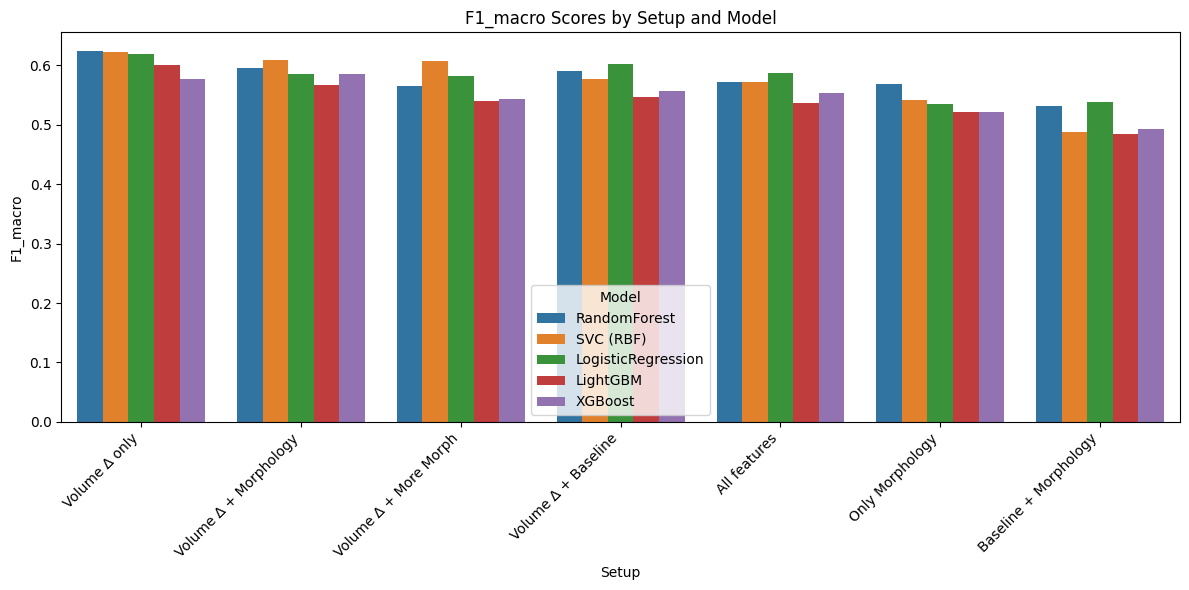

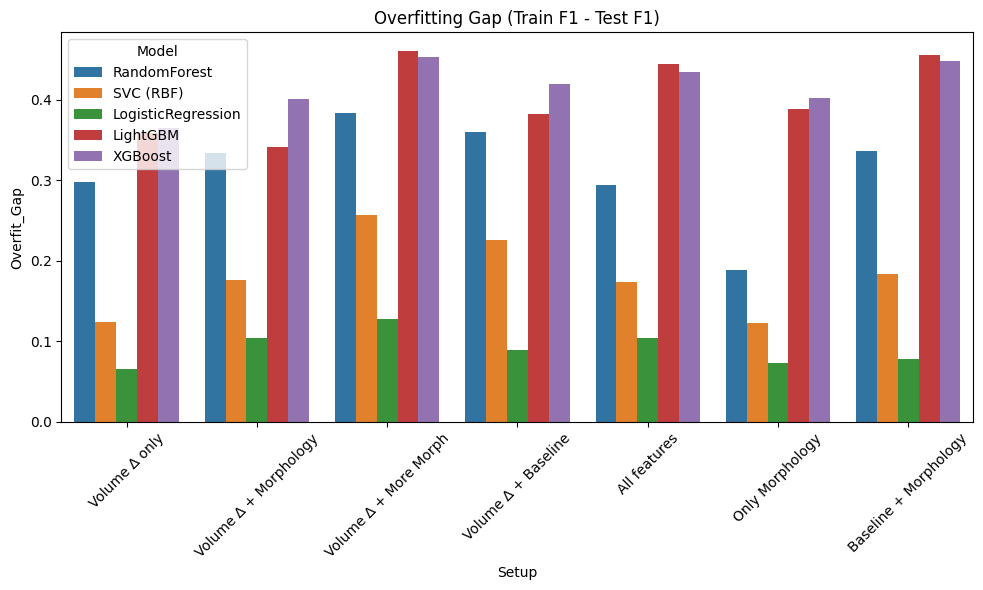

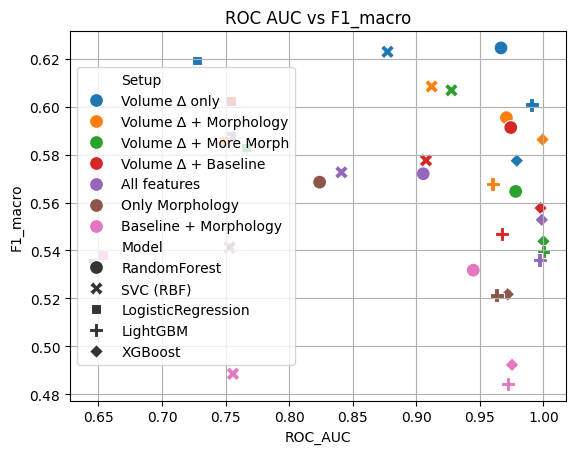

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Setup", y="F1_macro", hue="Model", ci="sd")
plt.xticks(rotation=45, ha='right')
plt.title("F1_macro Scores by Setup and Model")
plt.tight_layout()
plt.show()

results_df["Overfit_Gap"] = results_df["Train_F1"] - results_df["F1_macro"]

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Setup", y="Overfit_Gap", hue="Model")
plt.title("Overfitting Gap (Train F1 - Test F1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.scatterplot(data=results_df, x="ROC_AUC", y="F1_macro", hue="Setup", style="Model", s=100)
plt.title("ROC AUC vs F1_macro")
plt.grid(True)
plt.show()





In [74]:
from scipy.stats import wilcoxon

# Example: compare Volume ∆ only vs Volume ∆ + Morphology (across the same model, e.g., RF)
f1_vol = results_df[(results_df["Setup"] == "Volume ∆ only") & (results_df["Model"] == "RandomForest")]["F1_macro"]
f1_vol_morph = results_df[(results_df["Setup"] == "Volume ∆ + Morphology") & (results_df["Model"] == "RandomForest")]["F1_macro"]

stat, p = wilcoxon(f1_vol, f1_vol_morph)
print(f"Wilcoxon test (Volume ∆ vs Volume ∆ + Morph): p = {p:.4f}")

for model in results_df["Model"].unique():
    vol = results_df[(results_df["Setup"] == "Volume ∆ only") & (results_df["Model"] == model)]["F1_macro"]
    vol_morph = results_df[(results_df["Setup"] == "Volume ∆ + Morphology") & (results_df["Model"] == model)]["F1_macro"]
    if not vol.empty and not vol_morph.empty:
        stat, p = wilcoxon(vol, vol_morph)
        print(f"{model}: p = {p:.4f}")



Wilcoxon test (Volume ∆ vs Volume ∆ + Morph): p = 1.0000
RandomForest: p = 1.0000
SVC (RBF): p = 1.0000
LogisticRegression: p = 1.0000
LightGBM: p = 1.0000
XGBoost: p = 1.0000


In [ ]:
# Optional saving
results_df.to_csv("ablation_test_scores.csv", index=False)


# Deeplearning Models for the Ablation Study

In [75]:
from torch import nn
import torch
from skorch.net import NeuralNet

# Patch NeuralNet.__doc__ to avoid AttributeError in NeuralNetClassifier
if NeuralNet.__doc__ is None:
    NeuralNet.__doc__ = "Temporary docstring to avoid AttributeError in NeuralNetClassifier."

from skorch.classifier import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

#####################################
# 🔹 Simple MLP Model with Tunable Layers
#####################################
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 2)  # binary classification output
        )

    def forward(self, x):
        return self.net(x)


#####################################
# 🔹 Simple ResNet for Tabular Data
#####################################
class ResNetTabular(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.block1 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
        )
        self.shortcut = nn.Linear(hidden_dim, hidden_dim)

        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        identity = x
        out = self.block1(x)
        out += self.shortcut(identity)
        out = self.relu(out)
        return self.output(out)


#####################################
# 🔹 TabNet Wrapper
#####################################
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class TabNetSklearn(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=10, output_dim=2, **kwargs):
        self.model = TabNetClassifier(input_dim=input_dim, output_dim=output_dim, **kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


In [92]:
## Dictionary for the three models

In [76]:
models = {
    "MLP": lambda input_dim: NeuralNetClassifier(
        module=SimpleMLP,
        module__input_dim=input_dim,
        max_epochs=100,
        lr=0.001,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        callbacks=[EarlyStopping(patience=10)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=0
    ),
    "ResNet": lambda input_dim: NeuralNetClassifier(
        module=ResNetTabular,
        module__input_dim=input_dim,
        max_epochs=100,
        lr=0.001,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        callbacks=[EarlyStopping(patience=10)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=0
    ),
    "TabNet": lambda input_dim: TabNetSklearn(
        input_dim=input_dim,
        output_dim=2,
        n_d=64,
        n_a=64,
        n_steps=5,
        verbose=0,
        seed=42,
        device_name='cuda' if torch.cuda.is_available() else 'cpu'
    )
}


## Tuning with Gridnet of the different models 

In [18]:
# Define your binary label
# Assumes: 1 = Response, 0 = No Response (PD + SD)
df["binary_response"] = df["response"].replace({"PD": 0, "SD": 0, "Response": 1})

# Optional: confirm label distribution
print(df["binary_response"].value_counts())

df["binary_response"] = df["response"].apply(lambda x: 1 if x == 3 else 0)
print(df["binary_response"].value_counts())

from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from torch import nn
import torch

# Define MLP again
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 2)
        )

    def forward(self, x):
        return self.net(x)

# Construct pipeline
def make_mlp_pipeline(input_dim):
    net = NeuralNetClassifier(
        module=SimpleMLP,
        module__input_dim=input_dim,
        max_epochs=50,
        lr=0.01,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        iterator_train__shuffle=True,
        callbacks=[EarlyStopping(patience=5)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=0
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', net)
    ])

# Define parameter grid
param_grid = {
    'clf__module__hidden_dim': [32, 64, 128],
    'clf__module__dropout': [0.1, 0.3, 0.5],
    'clf__lr': [0.001, 0.01],
}

# Prepare data
df_clean = df.dropna(subset=features + ["binary_response", "patient_id"])
X = df_clean[features].values.astype(np.float32)
y = df_clean["binary_response"].values.astype(np.int64)
groups = df_clean["patient_id"]
input_dim = X.shape[1]

# Create and run grid search
pipe = make_mlp_pipeline(input_dim)
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    cv=GroupKFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X, y, groups=groups)

# Best result
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Macro:", grid_search.best_score_)


binary_response
3    157
2     44
0     21
1     13
Name: count, dtype: int64
binary_response
1    157
0     78
Name: count, dtype: int64
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=  18.0s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.1s
[CV] END clf__lr=0.001, c

In [19]:
import joblib
from pathlib import Path
Path("tuned_models").mkdir(exist_ok=True)  # Ensure the save directory exists

# Create and run grid search
pipe = make_mlp_pipeline(input_dim)
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    cv=GroupKFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X, y, groups=groups)

# Best result
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Macro:", grid_search.best_score_)

# 💾 Save best estimator
torch.save(grid_search.best_estimator_, "tuned_models/mlp_best.pt")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hid

In [20]:
# Resnet Pipeline for Hyperparameter finetuning 
def make_resnet_pipeline(input_dim):
    net = NeuralNetClassifier(
        module=ResNetTabular,
        module__input_dim=input_dim,
        max_epochs=50,
        lr=0.01,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        iterator_train__shuffle=True,
        callbacks=[EarlyStopping(patience=5)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=0
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', net)
    ])

resnet_param_grid = {
    'clf__module__hidden_dim': [64, 128, 256],
    'clf__module__dropout': [0.2, 0.4],
    'clf__lr': [0.001, 0.01],
}

# Same code as before, just change pipeline and param grid
resnet_pipe = make_resnet_pipeline(input_dim)
resnet_grid = GridSearchCV(
    resnet_pipe,
    param_grid=resnet_param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    cv=GroupKFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)

resnet_grid.fit(X, y, groups=groups)
print("Best ResNet Params:", resnet_grid.best_params_)
print("Best ResNet F1:", resnet_grid.best_score_)

# 💾 Save best estimator
torch.save(resnet_grid.best_estimator_, "tuned_models/resnet_best.pt")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=64; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=64; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=64; total time=   0.4s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=64; total time=   0.4s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=64; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=128; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=128; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=128; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module__hidden_dim=128; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.2, clf__module_

In [32]:
import torch
from torch.serialization import add_safe_globals

# Import or define your custom classes
from torch.serialization import add_safe_globals

add_safe_globals([SimpleMLP, ResNetTabular])

# Tell torch these are safe
add_safe_globals([SimpleMLP, ResNetTabular])

# Now load the models
mlp_best = torch.load("tuned_models/mlp_best.pt", weights_only=False)
resnet_best = torch.load("tuned_models/resnet_best.pt", weights_only=False)


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch.nn.modules.container.Sequential was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch.nn.modules.container.Sequential])` or the `torch.serialization.safe_globals([torch.nn.modules.container.Sequential])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

# Ablation Study Results - Which combos are we doing (from Minimal -> to All Features)

In [25]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib
from pathlib import Path

# Load best models
mlp = joblib.load("tuned_models/mlp_best.pkl")
resnet = joblib.load("tuned_models/resnet_best.pkl")
tabnet = joblib.load("tuned_models/tabnet_best.pkl")

# Define model dictionary
models = {
    "MLP": mlp,
    "ResNet": resnet,
    "TabNet": tabnet
}

# GroupKFold setup
gkf = GroupKFold(n_splits=5)

# Result container
results_nn = []

# Loop over ablation setups
for setup_name, features in ablation_setups.items():
    df_clean = df.dropna(subset=features + ["binary_response", "patient_id"])
    X = df_clean[features].values.astype(np.float32)
    y = df_clean["binary_response"].values.astype(np.int64)
    groups = df_clean["patient_id"]

    for model_name, model in models.items():
        print(f"Evaluating {model_name} on setup: {setup_name}")

        if model_name == "TabNet":
            y_pred = cross_val_predict(model, X, y, cv=gkf, groups=groups)
            y_prob = cross_val_predict(model, X, y, cv=gkf, groups=groups, method="predict_proba")[:, 1]
        else:
            pipeline = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", model)
            ])
            y_pred = cross_val_predict(pipeline, X, y, cv=gkf, groups=groups)
            y_prob = cross_val_predict(pipeline, X, y, cv=gkf, groups=groups, method="predict_proba")[:, 1]

        results_nn.append({
            "Setup": setup_name,
            "Model": model_name,
            "F1_macro": f1_score(y, y_pred, average='macro'),
            "ROC_AUC": roc_auc_score(y, y_prob),
            "Accuracy": accuracy_score(y, y_pred)
        })

# Display as DataFrame
results_tuned_nn_df = pd.DataFrame(results_nn).sort_values(by="F1_macro", ascending=False)


FileNotFoundError: [Errno 2] No such file or directory: 'tuned_models/mlp_best.pkl'

In [26]:
import joblib
# Define parameter grid
param_grid = {
    'clf__module__hidden_dim': [32, 64, 128],
    'clf__module__dropout': [0.1, 0.3, 0.5],
    'clf__lr': [0.001, 0.01],
}

# Prepare data
df_clean = df.dropna(subset=features + ["binary_response", "patient_id"])
X = df_clean[features].values.astype(np.float32)
y = df_clean["binary_response"].values.astype(np.int64)
groups = df_clean["patient_id"]
input_dim = X.shape[1]

# Create and run grid search
pipe = make_mlp_pipeline(input_dim)
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    cv=GroupKFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X, y, groups=groups)

# Best result
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Macro:", grid_search.best_score_)

def make_resnet_pipeline(input_dim):
    net = NeuralNetClassifier(
        module=ResNetTabular,
        module__input_dim=input_dim,
        max_epochs=50,
        lr=0.01,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        iterator_train__shuffle=True,
        callbacks=[EarlyStopping(patience=5)],
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=0
    )
    return Pipeline([
        ('scaler', StandardScaler()),
        ('clf', net)
    ])

resnet_param_grid = {
    'clf__module__hidden_dim': [64, 128, 256],
    'clf__module__dropout': [0.2, 0.4],
    'clf__lr': [0.001, 0.01],
}

# Same code as before, just change pipeline and param grid
resnet_pipe = make_resnet_pipeline(input_dim)
resnet_grid = GridSearchCV(
    resnet_pipe,
    param_grid=resnet_param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    cv=GroupKFold(n_splits=5),
    n_jobs=-1,
    verbose=2
)
resnet_grid.fit(X, y, groups=groups)
print("Best ResNet Params:", resnet_grid.best_params_)
print("Best ResNet F1:", resnet_grid.best_score_)



Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=32; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.1s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.3s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hidden_dim=64; total time=   0.2s
[CV] END clf__lr=0.001, clf__module__dropout=0.1, clf__module__hid

In [27]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.metrics import f1_score
import numpy as np
import joblib
import os

# Parameter space
tabnet_param_grid = {
    'n_d': [8, 16, 32],
    'n_a': [8, 16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.3, 1.5],
    'momentum': [0.02, 0.04],
    'lr': [0.001, 0.01]  # ✅ We’ll use this in optimizer_params
}

# Random sampler
n_iter = 5
param_samples = list(ParameterSampler(tabnet_param_grid, n_iter=n_iter, random_state=42))

best_f1 = 0
best_model = None
best_params = None

skf = StratifiedKFold(n_splits=5)
os.makedirs("tuned_models", exist_ok=True)

for params in param_samples:
    print(f"🔍 Trying: {params}")
    params = params.copy()
    lr = params.pop("lr")

    # ✅ Pass lr via optimizer_params
    model = TabNetClassifier(
        optimizer_params={'lr': lr},
        **params
    )

    f1s = []
    for train_idx, val_idx in skf.split(X, y):
        model.fit(
            X[train_idx], y[train_idx],
            max_epochs=50,
            patience=10,
            batch_size=1024,
            virtual_batch_size=128
        )
        preds = model.predict(X[val_idx])
        f1s.append(f1_score(y[val_idx], preds, average='macro'))

    avg_f1 = np.mean(f1s)
    print(f"📈 F1 Macro: {avg_f1:.4f}")

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_model = model
        best_params = {**params, "lr": lr}

print("✅ Best TabNet F1:", best_f1)
print("📌 Best TabNet Params:", best_params)

# ✅ Save best model
joblib.dump(best_model, "tuned_models/tabnet_best.pkl")


🔍 Trying: {'n_steps': 3, 'n_d': 16, 'n_a': 16, 'momentum': 0.04, 'lr': 0.01, 'gamma': 1.5}
epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0 

/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


['tuned_models/tabnet_best.pkl']

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from skorch import NeuralNetClassifier
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split


results_nn = []
gkf = GroupKFold(n_splits=5)

for setup_name, features in ablation_setups.items():
    df_clean = df_merged.dropna(subset=features + ["binary_response", "patient_id"])
    X = df_clean[features].values.astype(np.float32)
    y = df_clean["binary_response"].values.astype(np.int64)
    groups = df_clean["patient_id"]
    input_dim = X.shape[1]

    for model_name, model_fn in models.items():
        print(f"Running {model_name} on setup: {setup_name}")
        
        if model_name == "TabNet":
            # TabNet doesn’t use scikit pipeline
            X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
            clf = model_fn(input_dim)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)[:, 1]
        else:
            pipe = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", model_fn(input_dim))
            ])
        from sklearn.model_selection import cross_val_predict

        y_pred = cross_val_predict(pipe, X, y, cv=gkf, groups=groups)
        from sklearn.model_selection import cross_val_predict

        y_pred = cross_val_predict(pipe, X, y, cv=gkf, groups=groups)
        y_prob = cross_val_predict(pipe, X, y, cv=gkf, groups=groups, method="predict_proba")[:, 1]

        results_nn.append({
            "Setup": setup_name,
            "Model": model_name,
            "F1_macro": f1_score(y, y_pred, average='macro'),
            "ROC_AUC": roc_auc_score(y, y_prob),
            "Accuracy": accuracy_score(y, y_pred)
        })



Running MLP on setup: Volume ∆ only
Running ResNet on setup: Volume ∆ only
Running TabNet on setup: Volume ∆ only


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Running MLP on setup: Volume ∆ + Baseline
Running ResNet on setup: Volume ∆ + Baseline
Running TabNet on setup: Volume ∆ + Baseline


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Running MLP on setup: Volume ∆ + More Morph
Running ResNet on setup: Volume ∆ + More Morph
Running TabNet on setup: Volume ∆ + More Morph


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Running MLP on setup: Volume ∆ + Morphology
Running ResNet on setup: Volume ∆ + Morphology
Running TabNet on setup: Volume ∆ + Morphology


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Running MLP on setup: Baseline + Morphology
Running ResNet on setup: Baseline + Morphology
Running TabNet on setup: Baseline + Morphology


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Running MLP on setup: Only Morphology
Running ResNet on setup: Only Morphology
Running TabNet on setup: Only Morphology


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


Running MLP on setup: All features
Running ResNet on setup: All features
Running TabNet on setup: All features


/gpfs/data/oermannlab/users/schula12/.conda/envs/skorch-env/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [91]:
# Convert neural net results to DataFrame
results_nn_df = pd.DataFrame(results_nn)
results_nn_df.sort_values("F1_macro", ascending=False)

# Combine with classical models
combined_results = pd.concat([results_df, results_nn_df], ignore_index=True)

# Sort for visibility
combined_results = combined_results.sort_values("F1_macro", ascending=False)
display(combined_results)


,Setup,Model,F1_macro,F1_std,Train_F1,ROC_AUC,Accuracy
0,Volume ∆ only,RandomForest,0.624509,0.100192,0.922559,0.966601,0.902128
1,Only Morphology,LogisticRegression,0.623823,0.091334,0.728522,0.729626,0.663830
2,Volume ∆ only,SVC (RBF),0.622903,0.110513,0.747082,0.878083,0.723404
3,Volume ∆ only,LogisticRegression,0.619286,0.041190,0.684411,0.727340,0.646809
4,Volume ∆ + Morphology,SVC (RBF),0.608431,0.074884,0.784615,0.912053,0.761702
5,Volume ∆ + Baseline,LogisticRegression,0.602379,0.131061,0.691450,0.754042,0.646809
6,Volume ∆ only,LightGBM,0.600831,0.111004,0.958991,0.990772,0.944681
7,Volume ∆ + Morphology,RandomForest,0.595416,0.095086,0.929766,0.970848,0.910638
8,Volume ∆ + Baseline,RandomForest,0.591300,0.080869,0.950495,0.974277,0.936170
9,All features,LogisticRegression,0.587612,0.089715,0.691729,0.753960,0.651064


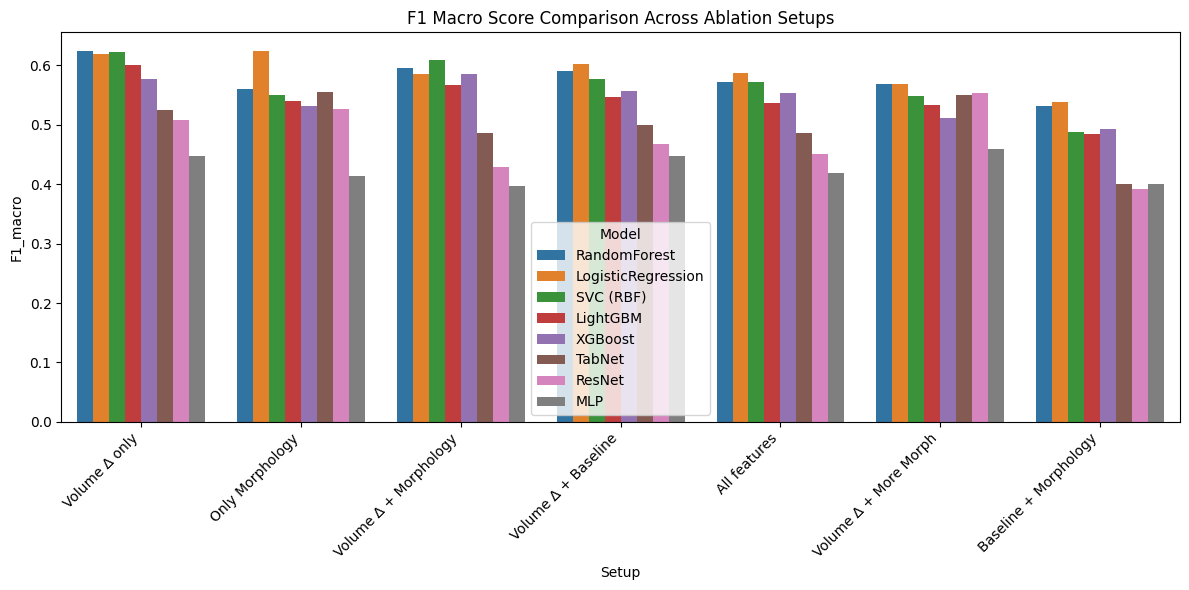

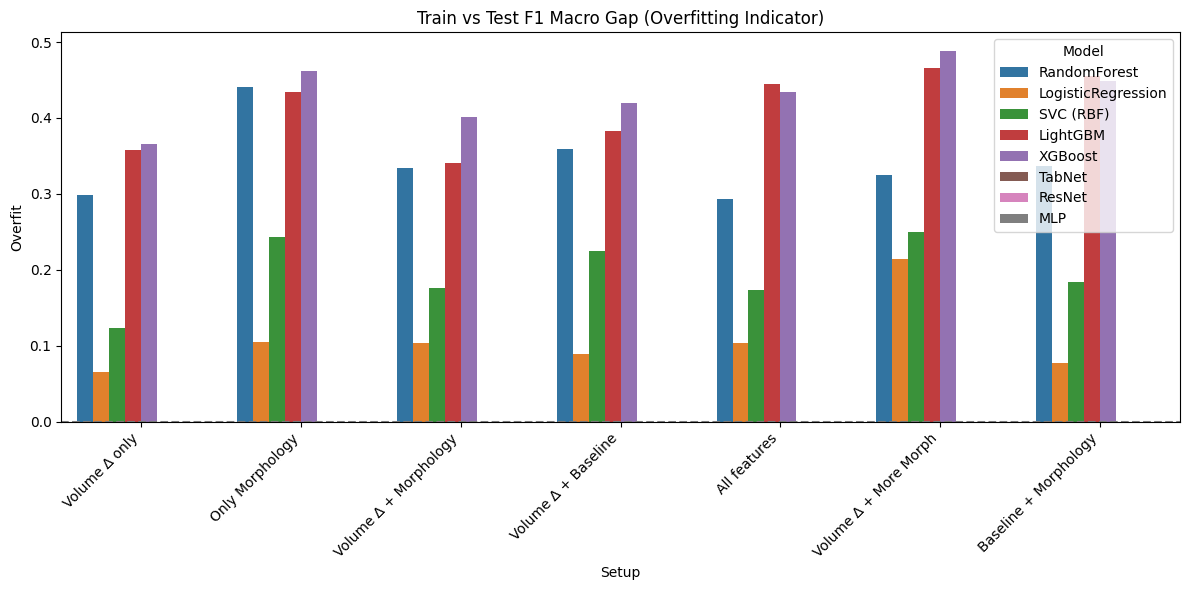

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_results, x="Setup", y="F1_macro", hue="Model")
plt.xticks(rotation=45, ha='right')
plt.title("F1 Macro Score Comparison Across Ablation Setups")
plt.tight_layout()
plt.show()

combined_results["Overfit"] = combined_results["Train_F1"] - combined_results["F1_macro"]

plt.figure(figsize=(12, 6))
sns.barplot(data=combined_results, x="Setup", y="Overfit", hue="Model")
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Train vs Test F1 Macro Gap (Overfitting Indicator)")
plt.tight_layout()
plt.show()

